# Validating Efficient Methods for Measuring Intertemporal Choice

### A Methodological Comparison of Two Procedures for Assessing Delayed Losses

This Jupyter Notebook provides a complete Python-based replication of the analyses from the publication:

> Wan, H., Green, L., & Myerson, J. (2024). Delayed monetary losses: Do different procedures and measures assess the same construct?. *Behavioural Processes, 222*, 105101. https://doi.org/10.1016/j.beproc.2024.105101

#### Project Objective
The goal of this study is **methodological validation**. It formally tests whether a brief, 27-item survey (the Delayed Losses Questionnaire, DLQ) yields a valid and reliable measure of delay discounting when compared to the more resource-intensive Adjusting-Amount (Adj-Amt) procedure.

#### Analysis Workflow
1.  **Setup**: Imports all necessary Python libraries and defines custom functions.
2.  **Data Processing**: Cleans and transforms the raw data, calculating the four key discounting measures.
3.  **Group-Level Analysis**: Visualizes aggregate choice patterns (Figure 1 replication) and fits non-linear models to assess data quality.
4.  **Reliability & Validity Analysis**: Assesses the reliability of measures within each procedure and the convergent validity between them.
5.  **Choice Pattern Analysis**: Categorizes and compares individual response styles across procedures.

The data are publicly available on the Open Science Framework: <https://osf.io/emb2q/>.

In [ ]:
# --- 1. Environment Setup ---
# This cell installs all the required Python packages.
# It is commented out by default. Uncomment and run if the packages are not yet installed.

# import sys
# !{sys.executable} -m pip install pandas numpy scipy lmfit statsmodels seaborn scikit-learn pingouin

In [ ]:
# --- 2. Imports and Custom Functions ---

# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings
from scipy.optimize import curve_fit
from scipy.stats import gmean, chi2_contingency

# --- Statistics and Modeling ---
from sklearn.metrics import auc as calculate_auc, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pingouin as pg

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Settings ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.float_format = '{:.3f}'.format


def set_plot_theme(ax, title="", xlabel="", ylabel=""):
    """Applies a consistent, publication-quality theme to a Matplotlib axes object."""
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', labelpad=10)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    if ax.get_legend():
        ax.legend(frameon=False)

## Data Processing

The raw data is loaded, filtered to the final sample (N = 431), and then transformed to calculate the four primary discounting scores:
- **For the Adj-Amt procedure**:
    1. `auc_adj_amt`: Area Under the Curve (atheoretical).
    2. `logk_adj_amt`: The log-transformed *k* parameter from a simple hyperbolic model (theoretical).
- **For the DLQ procedure**:
    1. `prop_imm_dlq`: The proportion of immediate choices (atheoretical).
    2. `logk_dlq`: The log-transformed *k* parameter estimated from the choice pattern (theoretical).

In [19]:
# --- 3. DATA LOADING AND PROCESSING ---

# --- Load and Clean Raw Data ---
data_raw = pd.read_csv("DelayLoss.csv", index_col=0)

# Filter to final sample based on criteria from the paper
data_clean = data_raw[
    (data_raw['check'] == 7) & (data_raw['provider'] != "MTurk")
].copy()
data_clean['id'] = data_clean.groupby('id').ngroup() + 1
data_clean = data_clean.drop(columns=['provider'])

# --- Calculate Scores for the Adjusting-Amount (Adj-Amt) Procedure ---
def calculate_adj_amt_scores(df_group):
    """Calculates AuC and log(k) for one participant's Adj-Amt data."""
    auc = calculate_auc(df_group['iv'] / 108, df_group['value'])
    def hyperbola(iv, k): return 1 / (1 + k * iv)
    try:
        params, _ = curve_fit(hyperbola, df_group['iv'], df_group['value'], p0=[0.01])
        logk = np.log(params[0])
    except (RuntimeError, ValueError):
        logk = np.nan
    return pd.Series({'auc_adj_amt': auc, 'logk_adj_amt': logk})

adj_amt_scores = data_clean[data_clean['procedure'] == "aa"].groupby(['id', 'amt']).apply(calculate_adj_amt_scores).reset_index()

# --- Calculate Scores for the Delayed Losses Questionnaire (DLQ) ---
def calculate_dlq_scores(df_group):
    """Calculates proportion of immediate choices and log(k) for one participant's DLQ data."""
    prop_immediate = df_group['value'].mean()
    choices = df_group['value'].values
    k_values = df_group['iv'].values
    if all(choices == 1): logk = np.log(k_values.min())
    elif all(choices == 0): logk = np.log(k_values.max())
    else:
        n_consistent = [sum((choices == 0) & (k_values <= k) | (choices == 1) & (k_values >= k)) for k in k_values]
        indifference_ks = k_values[np.where(n_consistent == np.max(n_consistent))]
        logk = np.log(gmean(indifference_ks))
    return pd.Series({'prop_imm_dlq': prop_immediate, 'logk_dlq': logk})

dlq_scores = data_clean[data_clean['procedure'] == "mcq"].groupby(['id', 'amt']).apply(calculate_dlq_scores).reset_index()

# --- Combine All Scores into a Single Tidy Dataframe ---
scores_combined = pd.merge(adj_amt_scores, dlq_scores, on=['id', 'amt'], how='outer')

# --- Classify Individual Choice Patterns ---

# 1. Classify patterns for the Adj-Amt procedure
adj_amt_patterns_raw = data_clean[
    (data_clean['procedure'] == 'aa') & (data_clean['amt'] != 3)
].groupby(['id', 'amt']).apply(lambda g: pd.Series({
    'correlation': g['value'].corr(np.log(g['iv'])),
    'mean_sv': g['value'].mean()
})).reset_index()

# Define global min/max for classification, as in the R script
min_val_aa = data_clean[data_clean['procedure'] == 'aa']['value'].min()
max_val_aa = data_clean[data_clean['procedure'] == 'aa']['value'].max()

# Apply classification logic
def classify_adj_amt(row):
    corr = 0 if pd.isna(row['correlation']) else row['correlation']
    if corr < 0 or row['mean_sv'] == min_val_aa: return "Typical"
    if corr > 0: return "Atypical"
    if row['mean_sv'] == max_val_aa: return "Always immediate"
    return "Typical" # Fallback
adj_amt_patterns_raw['pattern'] = adj_amt_patterns_raw.apply(classify_adj_amt, axis=1)

# Check for consistency across amounts for each participant
adj_amt_patterns = adj_amt_patterns_raw.groupby('id')['pattern'].apply(
    lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent"
).reset_index(name='pattern_adj_amt')

# 2. Classify patterns for the DLQ procedure
dlq_patterns_raw = data_clean[
    (data_clean['procedure'] == 'mcq') & (data_clean['amt'] != 2)
].groupby(['id', 'amt']).apply(lambda g: pd.Series({
    'correlation': g['value'].corr(np.log(g['iv'])),
    'mean_choice': g['value'].mean()
})).reset_index()

def classify_dlq(row):
    corr = 0 if pd.isna(row['correlation']) else row['correlation']
    if corr > 0 or row['mean_choice'] == 0: return "Typical"
    if corr < 0: return "Atypical"
    if row['mean_choice'] == 1: return "Always immediate"
    return "Undefined" # Fallback
dlq_patterns_raw['pattern'] = dlq_patterns_raw.apply(classify_dlq, axis=1)

dlq_patterns = dlq_patterns_raw.groupby('id')['pattern'].apply(
    lambda g: g.iloc[0] if g.nunique() == 1 else "Inconsistent"
).reset_index(name='pattern_dlq')

# 3. Join pattern classifications for the final contingency analysis
pattern_consistency = pd.merge(adj_amt_patterns, dlq_patterns, on="id")

print("Data processing complete.")

Data processing complete.


## Group-Level Analysis

This section replicates Figure 1 from the publication, visualizing the aggregate discounting patterns for both procedures. The plots confirm that the data conform to established findings, and goodness-of-fit statistics confirm that the chosen non-linear models describe the data well.

In [ ]:
# --- 4. GROUP-LEVEL ANALYSIS (FIGURE 1 REPLICATION) ---

# --- Prepare Group-Level Data ---
data_group_level = data_clean.groupby(['procedure', 'amt', 'iv']).agg(mean_value=('value', 'mean')).reset_index()

# --- Create Plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Adjusting-Amount Procedure
adj_amt_grp = data_group_level[data_group_level['procedure'] == 'aa']
adj_amt_grp['amount_label'] = pd.Categorical(adj_amt_grp['amt'].replace({1: "$90", 2: "$240", 3: "$1,500"}))
sns.scatterplot(data=adj_amt_grp, x='iv', y='mean_value', hue='amount_label', style='amount_label', s=100, ax=axes[0], edgecolor='k')

# Fit and plot hyperboloid curves
for amount_cat in adj_amt_grp['amount_label'].unique():
    subset = adj_amt_grp[adj_amt_grp['amount_label'] == amount_cat]
    def hyperbola(iv, k, s): return 1 / (1 + np.exp(k) * iv)**s
    try:
        params, _ = curve_fit(hyperbola, subset['iv'], subset['mean_value'], p0=[-4, 1])
        x_pred = np.linspace(subset['iv'].min(), subset['iv'].max(), 100)
        axes[0].plot(x_pred, hyperbola(x_pred, *params), color=sns.color_palette()[list(adj_amt_grp['amount_label'].unique()).index(amount_cat)])
    except RuntimeError:
        pass
set_plot_theme(axes[0], title="Adjusting-Amount Procedure", xlabel="Delay (months)", ylabel="Relative Subjective Value")

# Panel 2: Delayed Losses Questionnaire
dlq_grp = data_group_level[data_group_level['procedure'] == 'mcq']
dlq_grp['amount_label'] = pd.Categorical(dlq_grp['amt'].replace({1: "$75-105", 2: "$150-180", 3: "$225-255"}))
sns.scatterplot(data=dlq_grp, x='iv', y='mean_value', hue='amount_label', style='amount_label', s=100, ax=axes[1], edgecolor='k')

# Fit and plot logistic curves
sns.regplot(data=dlq_grp, x='iv', y='mean_value', logistic=True, scatter=False, ci=None, ax=axes[1], line_kws={'lw': 2})
axes[1].set_xscale('log')
set_plot_theme(axes[1], title="Delayed Losses Questionnaire", xlabel="Question k Parameter", ylabel="Choice of Immediate Payment")

plt.tight_layout()
plt.show()

# --- Goodness-of-Fit (R-squared) ---
print("--- R-squared for Group-Level Fits ---")
adj_amt_r2 = adj_amt_grp.groupby('amount_label').apply(lambda g: r2_score(g['mean_value'], hyperbola(g['iv'], *curve_fit(hyperbola, g['iv'], g['mean_value'], p0=[-4,1])[0]))).rename('Adj-Amt R2')
print(adj_amt_r2)

In [ ]:
# --- Reliability Analysis ---
print("--- Reliability: Correlations Between Amounts ---")
behav_long = behav.melt(id_vars=['id', 'procedure', 'amt'], value_vars=['atheoretical', 'k'],
                        var_name='measure', value_name='score')
reliability_pivot = behav_long.pivot_table(index=['id', 'procedure', 'measure'], columns='amt', values='score')
print(reliability_pivot.groupby(['procedure', 'measure']).corr())


print("\n--- Reliability: Correlations Between Measures (Atheoretical vs. Theoretical) ---")
print(behav.groupby(['procedure', 'amt'])[['atheoretical', 'k']].corr().unstack().iloc[:, 1])

## Analysis of Choice Patterns

This section categorizes participants based on their response patterns (e.g., typical, always immediate, atypical) and examines the consistency of these patterns across the two procedures.

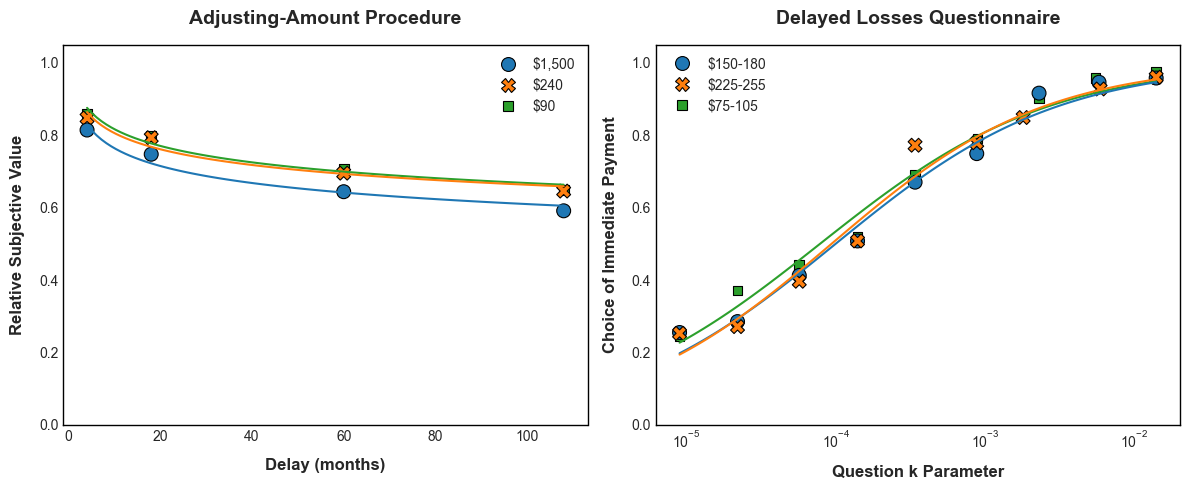

--- R-squared for Group-Level Fits ---
amount_label
$1,500   0.965
$240     0.957
$90      0.962
Name: Adj-Amt R2, dtype: float64

--- R-squared for DLQ Group-Level Fits ---
amount_label
$150-180   0.984
$225-255   0.976
$75-105    0.984
Name: DLQ R2, dtype: float64


In [ ]:
# --- 4. GROUP-LEVEL ANALYSIS (FIGURE 1 REPLICATION) ---

# --- Prepare Group-Level Data ---
data_group_level = data_clean.groupby(['procedure', 'amt', 'iv']).agg(mean_value=('value', 'mean')).reset_index()

# --- Create Plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Panel 1: Adjusting-Amount Procedure ---
adj_amt_grp = data_group_level[data_group_level['procedure'] == 'aa']
adj_amt_grp['amount_label'] = pd.Categorical(adj_amt_grp['amt'].replace({1: "$90", 2: "$240", 3: "$1,500"}))
sns.scatterplot(data=adj_amt_grp, x='iv', y='mean_value', hue='amount_label', style='amount_label', s=100, ax=axes[0], edgecolor='k')

# Fit and plot hyperboloid curves
for amount_cat in adj_amt_grp['amount_label'].unique():
    subset = adj_amt_grp[adj_amt_grp['amount_label'] == amount_cat]
    def hyperbola(iv, k, s): return 1 / (1 + np.exp(k) * iv)**s
    try:
        params, _ = curve_fit(hyperbola, subset['iv'], subset['mean_value'], p0=[-4, 1])
        x_pred = np.linspace(subset['iv'].min(), subset['iv'].max(), 100)
        axes[0].plot(x_pred, hyperbola(x_pred, *params), color=sns.color_palette()[list(adj_amt_grp['amount_label'].cat.categories).index(amount_cat)])
    except RuntimeError:
        pass
axes[0].set_ylim(0, 1.05)
set_plot_theme(axes[0], title="Adjusting-Amount Procedure", xlabel="Delay (months)", ylabel="Relative Subjective Value")

# --- Panel 2: Delayed Losses Questionnaire ---
dlq_grp = data_group_level[data_group_level['procedure'] == 'mcq']
dlq_grp['amount_label'] = pd.Categorical(dlq_grp['amt'].replace({1: "$75-105", 2: "$150-180", 3: "$225-255"}))
sns.scatterplot(data=dlq_grp, x='iv', y='mean_value', hue='amount_label', style='amount_label', s=100, ax=axes[1], edgecolor='k')

# Fit and plot the custom logistic function from the R script
for amount_cat in dlq_grp['amount_label'].unique():
    subset = dlq_grp[dlq_grp['amount_label'] == amount_cat]
    # Define the custom logistic model used in the R code
    def custom_logistic(log_k_iv, x, r):
        return 1 / (1 + np.exp(-(np.log(log_k_iv) - x) * r))
    try:
        params, _ = curve_fit(custom_logistic, subset['iv'], subset['mean_value'], p0=[-10, 1], maxfev=5000)
        # Generate prediction line on a log scale
        x_pred = np.logspace(np.log10(subset['iv'].min()), np.log10(subset['iv'].max()), 100)
        axes[1].plot(x_pred, custom_logistic(x_pred, *params), color=sns.color_palette()[list(dlq_grp['amount_label'].cat.categories).index(amount_cat)])
    except RuntimeError:
        pass
axes[1].set_xscale('log')
axes[1].set_ylim(0, 1.05)
set_plot_theme(axes[1], title="Delayed Losses Questionnaire", xlabel="Question k Parameter", ylabel="Choice of Immediate Payment")

plt.tight_layout()
plt.show()

# --- Goodness-of-Fit (R-squared) ---
print("--- R-squared for Group-Level Fits ---")
adj_amt_r2 = adj_amt_grp.groupby('amount_label', observed=True).apply(
    lambda g: r2_score(g['mean_value'], hyperbola(g['iv'], *curve_fit(hyperbola, g['iv'], g['mean_value'], p0=[-4,1])[0]))
).rename('Adj-Amt R2')
print(adj_amt_r2)

# Added R-squared calculation for the DLQ procedure
print("\n--- R-squared for DLQ Group-Level Fits ---")
def r2_dlq_fit(g):
    def model_func(log_k_iv, x, r): return 1 / (1 + np.exp(-(np.log(log_k_iv) - x) * r))
    params, _ = curve_fit(model_func, g['iv'], g['mean_value'], p0=[-10, 1], maxfev=5000)
    predictions = model_func(g['iv'], *params)
    return r2_score(g['mean_value'], predictions)

dlq_r2 = dlq_grp.groupby('amount_label', observed=True).apply(r2_dlq_fit).rename('DLQ R2')
print(dlq_r2)

## Reliability and Validity Analysis

This is the core of the study. **Reliability** is assessed by correlating measures *within* each procedure. **Concurrent validity** is checked by correlating atheoretical and theoretical measures. Finally, **convergent validity** is tested by correlating measures *between* the two procedures for the common loss amounts.

In [20]:
# --- 5. INDIVIDUAL-LEVEL RELIABILITY AND VALIDITY ---

# --- Within-Procedure Reliability (Alternate-Forms) ---
print("--- Reliability: Correlations Between Amounts Within Each Procedure ---")
# Pivot to wide format to easily calculate correlations between amount columns
auc_adj_amt_wide = scores_combined.pivot(index='id', columns='amt', values='auc_adj_amt')
prop_imm_dlq_wide = scores_combined.pivot(index='id', columns='amt', values='prop_imm_dlq')
print("Adj-Amt (AUC):\n", auc_adj_amt_wide.corr().round(3))
print("\nDLQ (Proportion Immediate):\n", prop_imm_dlq_wide.corr().round(3))


# --- Within-Procedure Concurrent Validity ---
print("\n--- Concurrent Validity: Correlations Between Atheoretical and Theoretical Measures ---")
print(scores_combined.groupby('amt')[['auc_adj_amt', 'logk_adj_amt']].corr().unstack().iloc[:,1].rename("Adj-Amt Corr"))
print(scores_combined.groupby('amt')[['prop_imm_dlq', 'logk_dlq']].corr().unstack().iloc[:,1].rename("DLQ Corr"))


# --- Between-Procedure Convergent Validity (Main Result) ---
# CORRECTED: This section now correctly matches the common amounts:
# - Adj-Amt Amount 1 ($90) vs. DLQ Amount 1 ($90 avg)
# - Adj-Amt Amount 2 ($240) vs. DLQ Amount 3 ($240 avg)
print("\n--- Convergent Validity: Correlations Between Procedures (Main Result) ---")
# Filter to the specific amounts for each procedure
adj_amt_90 = scores_combined[scores_combined['amt'] == 1][['id', 'auc_adj_amt', 'logk_adj_amt']]
dlq_90 = scores_combined[scores_combined['amt'] == 1][['id', 'prop_imm_dlq', 'logk_dlq']]
adj_amt_240 = scores_combined[scores_combined['amt'] == 2][['id', 'auc_adj_amt', 'logk_adj_amt']]
dlq_240 = scores_combined[scores_combined['amt'] == 3][['id', 'prop_imm_dlq', 'logk_dlq']]

# Merge the matched datasets
corr_df_90 = pd.merge(adj_amt_90, dlq_90, on='id')
corr_df_240 = pd.merge(adj_amt_240, dlq_240, on='id')

# Calculate and display correlations
results = {
    "Amount_Match": ["$90 vs $90", "$240 vs $240"],
    "Atheoretical_Corr": [
        corr_df_90[['auc_adj_amt', 'prop_imm_dlq']].corr().iloc[0,1],
        corr_df_240[['auc_adj_amt', 'prop_imm_dlq']].corr().iloc[0,1]
    ],
    "Theoretical_Corr": [
        corr_df_90[['logk_adj_amt', 'logk_dlq']].corr().iloc[0,1],
        corr_df_240[['logk_adj_amt', 'logk_dlq']].corr().iloc[0,1]
    ]
}
print(pd.DataFrame(results).round(3))

--- Reliability: Correlations Between Amounts Within Each Procedure ---
Adj-Amt (AUC):
 amt     1     2     3
amt                  
1   1.000 0.782 0.636
2   0.782 1.000 0.763
3   0.636 0.763 1.000

DLQ (Proportion Immediate):
 amt     1     2     3
amt                  
1   1.000 0.866 0.806
2   0.866 1.000 0.893
3   0.806 0.893 1.000

--- Concurrent Validity: Correlations Between Atheoretical and Theoretical Measures ---
amt
1   -0.960
2   -0.968
3   -0.967
Name: Adj-Amt Corr, dtype: float64
amt
1   -0.981
2   -0.982
3   -0.977
Name: DLQ Corr, dtype: float64

--- Convergent Validity: Correlations Between Procedures (Main Result) ---
   Amount_Match  Atheoretical_Corr  Theoretical_Corr
0    $90 vs $90              0.735             0.728
1  $240 vs $240              0.777             0.773


## Analysis of Choice Patterns

Finally, this section examines whether individuals show consistent *qualitative* patterns of choice across the two procedures. A contingency table analysis tests if a participant's classification on one procedure is significantly associated with their classification on the other.

In [21]:
# --- 6. ANALYSIS OF CHOICE PATTERNS ---

# --- Frequencies of Choice Patterns by Procedure ---
print("--- Frequencies of Choice Patterns by Procedure ---")
adj_amt_counts = pattern_consistency['pattern_adj_amt'].value_counts(normalize=True)
dlq_counts = pattern_consistency['pattern_dlq'].value_counts(normalize=True)
pattern_summary = pd.DataFrame({'Adj-Amt': adj_amt_counts, 'DLQ': dlq_counts})
print(pattern_summary.round(3))


# --- Contingency Table and Chi-Squared Test ---
print("\n--- Cross-Tabulation of Choice Patterns (Observed Counts) ---")
contingency_table = pd.crosstab(
    pattern_consistency['pattern_adj_amt'],
    pattern_consistency['pattern_dlq']
)
print(contingency_table)

# Perform Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-Squared Test:\nChi2 = {chi2:.2f}, p-value = {p:.4f}, df = {dof}")

print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns).round(2))

--- Frequencies of Choice Patterns by Procedure ---
                  Adj-Amt   DLQ
Always immediate    0.165 0.155
Atypical            0.019 0.002
Inconsistent        0.193 0.084
Typical             0.624 0.759

--- Cross-Tabulation of Choice Patterns (Observed Counts) ---
pattern_dlq       Always immediate  Atypical  Inconsistent  Typical
pattern_adj_amt                                                    
Always immediate                56         0            10        5
Atypical                         2         0             1        5
Inconsistent                     8         0            13       62
Typical                          1         1            12      255

Chi-Squared Test:
Chi2 = 296.31, p-value = 0.0000, df = 9

Expected Frequencies:
pattern_dlq       Always immediate  Atypical  Inconsistent  Typical
pattern_adj_amt                                                    
Always immediate            11.040     0.160         5.930   53.870
Atypical                     1.